# Simiosis gia Grid
- o skopos tou na dimiourgisw ena grid einai gia na miosw kata poli to sinolo ton simion sto disance join
- auto epitinxanete ftiaxnontas ena MBB pernontas ta min ton max(x,y) kai apo ta 2 data sets kathos kai ta max apo ta min(x,y) me tin logiki oti osa simia einai ektos tou min max x enos apo ta 2 dataset den ikanopoioun tin sinthiki theta.
- stin sinexia tha prepei na kanw spatial join to grid kai me ta 2 datasets gia na vrw se poio grid paei kathe simio
- meta tha aporipsw osa grids den exoun kanena

### Xrisima stixia na periexei ena grid
- gridId
- polygon
- TODO Check id x an y needed for partitioning reasons

### Idea gia grid filtering
- Na kanw spatial join mono sto dataset me ta ligotera simia prokimenou na filtrarw ta grids pou den exeoun kanena simio apo to Dataset auto
- Me auton ton tropo epitinxanw na kanw mikrotero spatial join sto dataset me tis perisoteres eggrafes
- auto vasizete sto

# Simiosis gia partitioning
- prepei na xorisw ta data mou se ola ta mixanimata prin ksekinisw to spatial join
- episis prepei na xorisw kai ta grids omiomorfa se ola ta mixanimata
- enas tropos gia na ta xorisw tha mporouse na einai to X. Diladi na vrw ta max kai min X kai paota 2 datasets gia na vrw to rangekai na kanw range partition os pros x gia ta points
- gia ta grids apo tin all tha eprepe na kanw partition os pros to max X tous oste na simenei oti oti grid einai sto partition exei points mono sto partition auto.
- me auton ton tropo epitinxanoume na exoume ta points kai ta grids tous mirasmena ana mixanima kai na empodisoume tis metakinisis sto diktio

### Pws to kanw auto?
- prepei na dw pws douleui to pratitioning
- pos simperiferete to join sto partitioning
- prepei na dw an ipostirizei kati tetoio i vivliothiki

## Imports

In [1]:
# Main  Imports
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.core.display import display
import time

# Local App Imports
from utils import spatialUtils as utils

# Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType

# Python shapely imports
from descartes import PolygonPatch
import shapely.speedups
shapely.speedups.enable() # this makes some spatial queries run faster

## Load Dataset

In [2]:
# full program timer
total_time = time.time()

test_sample_A_path = "../../testData/ais_one_hour_25k.csv"
test_sample_B_path = "../../testData/ais_one_hour2_25k.csv"

theta = 10
distanceType = "euclidean"

# create sedona spark session
spark = SparkSession.builder.appName("DistributedDistanceJoin_Test").master("local").getOrCreate()


# Load CSV File
df_a = spark.read.csv(header="True", inferSchema="True", path=test_sample_A_path)
df_a.show(10)

df_b = spark.read.csv(header="True", inferSchema="True", path=test_sample_B_path)
df_b.show(10)


+--------------------+----------+---------+
|                 _id|         X|        Y|
+--------------------+----------+---------+
|60039bef2bc024099...|  -4.50088| 48.35698|
|60039b8f2bc024099...|-4.4970617|48.379555|
|60039b9c2bc024099...|-4.4137635| 48.15062|
|60039bef2bc024099...| -4.500963|48.356915|
|60039bbe2bc024099...| -4.474253|48.341007|
|60039bef2bc024099...| -4.501045|48.356842|
|60039a6c2bc024099...| -4.497015|48.382206|
|60039c032bc024099...|  -4.56926| 48.13976|
|60039e032bc024099...| -4.476655| 48.38109|
|60039bef2bc024099...| -4.501128|48.356773|
+--------------------+----------+---------+
only showing top 10 rows

+--------------------+----------+---------+
|                 _id|         X|        Y|
+--------------------+----------+---------+
|600399bc2bc024099...|-4.5935817| 48.13648|
|60039df12bc024099...| -4.758715| 48.06632|
|60039bbe2bc024099...| -4.472955|48.340054|
|60039e102bc024099...| -4.678545|48.304527|
|600399bc2bc024099...|  -4.59364| 48.13646|
|60039

## Grid Dataset
Lets create a test grid
- We have to find the MBB from the dataset with less records
- Then we have to create a grid for this dataset (**sos** each grid side has to be equal to theta)
- Then calculate expanded grids for each grid

### Times:
first run --- 4.288848161697388 seconds ---

In [3]:
def calculate_minimum_grid_from_sdf(sdf1, sdf2, theta=10):
    """
    This Helper func takes 2 spark dataframe and:
     1) founds their MBB's using calculate_MBB_from_sdf helper func
     2) then compairs the sum of each MBB dx and dy and selects the MBB the minimum
     3) Calculates the grid for the minimum MBB
    :param sdf1: first pointset dataframe
    :param sdf2: second pointset dataframe
    :param theta: distance theta given by user
    :return:
     - grid: For the minimum MBB
     - isPointSetA: A boolean flag tha indicates if the minimum MBB is for pointset A or not
    """
    mbb_row1, dx1, dy1 = calculate_MBB_from_sdf(sdf1)
    mbb_row2, dx2, dy2 = calculate_MBB_from_sdf(sdf2)

    if (dx1 * dy1) <= (dx2 * dy2):
        return calculate_grid_from_MBB(mbb_row1, theta=theta), True
    else:
        return calculate_grid_from_MBB(mbb_row2, theta=theta), False


def calculate_MBB_from_sdf(sdf):
    # find min/max X,Y
    mbb_row = sdf.agg(
        F.max(sdf.X),
        F.min(sdf.X),
        F.max(sdf.Y),
        F.min(sdf.Y),
    ).collect()[0]
    print("print mbb: {}".format(mbb_row))

    # calculate dx and dy
    dx = mbb_row["max(X)"] - mbb_row["min(X)"]
    dy = mbb_row["max(Y)"] - mbb_row["min(Y)"]

    return mbb_row, dx, dy


def calculate_grid_from_MBB(mbb_row, theta):
    # calculate grid for dataset
    return utils.getPolyGrid(mbb_row["min(X)"],
                             mbb_row["min(Y)"],
                             mbb_row["max(X)"],
                             mbb_row["max(Y)"], theta=theta)




In [4]:
# Grid dataset with minimum MBB
create_grid_time = time.time()

grid, isPointSetA = calculate_minimum_grid_from_sdf(df_a, df_b, theta=theta)

# log grid generation stats
print("grid len: {}".format(len(grid)))
print("--- %s seconds ---" % (time.time() - create_grid_time))

# swap df_a with df_b if needed:
# this block of code will run if dataset B has smaller MBB from A because we want the df_a to be
# the smallest MBB dataset
if not isPointSetA:
    temp_df = df_b
    df_b = df_a
    df_a = temp_df

# Create Grid RDD or DF
grid_df = spark.createDataFrame(grid)

print mbb: Row(max(X)=-0.066665, min(X)=-7.0706515, max(Y)=50.439285, min(Y)=45.95756)
print mbb: Row(max(X)=-3.441525, min(X)=-6.7022815, max(Y)=49.538467, min(Y)=47.040787)
grid len: 2173
--- 3.4336600303649902 seconds ---


## Plot Grid And Points

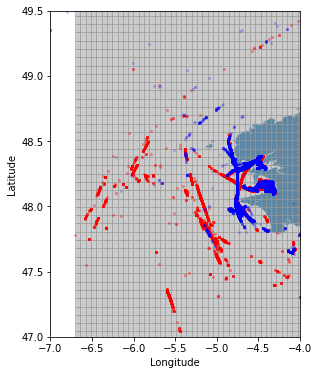

In [5]:
# print grids
ax = utils.createAXNFigure(coastline_path="../../testData/EuropeanCoastline/Europe Coastline (Polygone).shp", zoom_in=True)
BLUE = '#6699cc'
GRAY = '#999999'
for cell in grid:
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.5, zorder=2, label="Grid"))

for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r', label=" A")

for row in df_b.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b', label=" B")

# plt.legend(loc="upper left")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Create Grid RDD or DF

In [6]:
grid_df = spark.createDataFrame(grid)
grid_df.printSchema()
print(grid_df.schema)
grid_df.show(10)

root
 |-- exp_grid_maxX: double (nullable = true)
 |-- exp_grid_maxY: double (nullable = true)
 |-- exp_grid_minX: double (nullable = true)
 |-- exp_grid_minY: double (nullable = true)
 |-- grid_id: long (nullable = true)
 |-- grid_maxX: double (nullable = true)
 |-- grid_maxY: double (nullable = true)
 |-- grid_minX: double (nullable = true)
 |-- grid_minY: double (nullable = true)

StructType(List(StructField(exp_grid_maxX,DoubleType,true),StructField(exp_grid_maxY,DoubleType,true),StructField(exp_grid_minX,DoubleType,true),StructField(exp_grid_minY,DoubleType,true),StructField(grid_id,LongType,true),StructField(grid_maxX,DoubleType,true),StructField(grid_maxY,DoubleType,true),StructField(grid_minX,DoubleType,true),StructField(grid_minY,DoubleType,true)))
+-------------+-------------+-------------+-------------+-------+---------+---------+---------+---------+
|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|
+-------------+-----

## Link Points tou Grids
- **Approach 1:** Test databricks code for spatial join from link
- **Approach 2:** perform spatial join in order to link points with grids
- **Approach 3:** perform spatial join without using intersection. use where statement on join and check if point is within grid box

### Results
It seems that approach 3 is 3 times faster than approach 2 because we dont need to check for intersection using apache
sedona because we use squares/grids as polygons and in this case we can easily check if point intersect with the square
grid by chacking max and min X,Y respectively. Despite that we dont need to use UDF function in order to conver X,Y coords into sapely point

### Approach 3

In [7]:
# timing procedure
start_time = time.time()

df_a.createOrReplaceTempView("points")
grid_df.createOrReplaceTempView("grids")

spatial_join_result = spark.sql(
    """
        SELECT *
        FROM points AS P join grids AS G
        WHERE P.X >= G.grid_minX and P.X <= G.grid_maxX
         and P.Y >= G.grid_minY and P.Y <= G.grid_maxY
    """
).cache() # cache results to avoid perform join again



print("--- %s seconds ---" % (time.time() - start_time))

# print some stats
spatial_join_result.show()
print(spatial_join_result.count())

--- 0.32090282440185547 seconds ---
+--------------------+----------+---------+-------------+-------------+-------------+-------------+-------+---------+---------+---------+---------+
|                 _id|         X|        Y|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|
+--------------------+----------+---------+-------------+-------------+-------------+-------------+-------+---------+---------+---------+---------+
|60039e4d2bc024099...| -6.586215| 47.90885|     -6.44065|     48.02257|      -6.7728|       47.779|     67| -6.57487| 47.93263| -6.63858| 47.86893|
|60039e4d2bc024099...| -6.586265|  47.9088|     -6.44065|     48.02257|      -6.7728|       47.779|     67| -6.57487| 47.93263| -6.63858| 47.86893|
|60039e4d2bc024099...|-6.5865817|  47.9085|     -6.44065|     48.02257|      -6.7728|       47.779|     67| -6.57487| 47.93263| -6.63858| 47.86893|
|60039e4d2bc024099...|-6.5868816|47.908134|     -6.44065|     48.02257|     

## Spatial join Approach 2 stats
- find count
- find pings per grid
- filter grids with 0 points

### SOS
Otan kanoume chaining functions mporoume na exoume access se colum apo to proigoumeno function kanontas F.col("coll_name")

In [8]:
print("spatial join count: {}".format(spatial_join_result.count()))

# find pings per grid
filtered_grid = spatial_join_result.groupby(["grid_id", "grid_maxX", "grid_maxY", "grid_minX", "grid_minY", "exp_grid_maxX", "exp_grid_maxY", "exp_grid_minX", "exp_grid_minY"])\
    .count()\
    .filter(F.col("count") > 0)\
    .cache()

filtered_grid.show(10)

print("filtered spatial join count: {}".format(filtered_grid.count()))

spatial join count: 25000
+-------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+
|grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|count|
+-------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+
|   1502| -4.34526| 47.93263| -4.40896| 47.86893|     -4.21103|     48.02257|     -4.54319|       47.779|   62|
|    227| -6.32006| 48.18745| -6.38376| 48.12374|     -6.18517|     48.27738|     -6.51866|     48.03381|    6|
|    968|  -5.1734| 47.99634| -5.23711| 47.93263|     -5.03901|     48.08627|      -5.3715|      47.8427|    5|
|    108| -6.51117| 47.93263| -6.57487| 47.86893|     -6.37695|     48.02257|      -6.7091|       47.779|    7|
|   1334| -4.60007| 48.18745| -4.66378| 48.12374|     -4.46518|     48.27738|     -4.79867|     48.03381|  286|
|   1456| -4.40896| 48.25115| -4.47267| 48.18745|      -4.2739|     48.34108| 

## Plot points with filtered grids

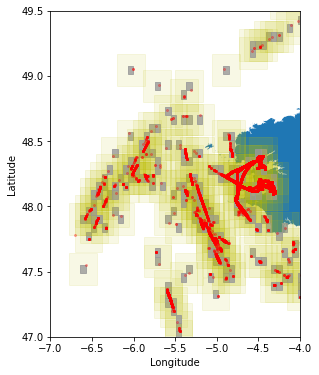

In [9]:
# print grids
ax = utils.createAXNFigure(coastline_path="../../testData/EuropeanCoastline/Europe Coastline (Polygone).shp", zoom_in=True)
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))


for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

# for row in df_b.collect():
#   ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

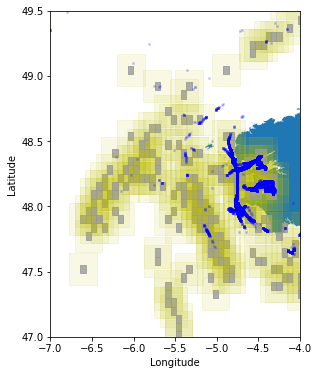

In [10]:
# print grids
ax = utils.createAXNFigure(coastline_path="../../testData/EuropeanCoastline/Europe Coastline (Polygone).shp", zoom_in=True)
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))


# for row in df_a.collect():
#   ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in df_b.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Perform Spatial Join With Point_set B And expanded gids

By performing this spatial join we can filter points not in expanded grids (if exist)
and keep only those points who have a chance to satisfy condition theta

for This spatial join we choose approach 3 from previous spatial join (datasetA with grids)

In [11]:
# timing procedure
start_time = time.time()

df_b.createOrReplaceTempView("points_B")
filtered_grid.createOrReplaceTempView("grids")

spatial_join_b_result = df_b.join(F.broadcast(filtered_grid), (
        (df_b.X >= filtered_grid.exp_grid_minX) &
        (df_b.X <= filtered_grid.exp_grid_maxX) &
        (df_b.Y >= filtered_grid.exp_grid_minY) &
        (df_b.Y <= filtered_grid.exp_grid_maxY)))\
        .withColumnRenamed("grid_id", "exp_grid_id")\
        .withColumn("grid_id", F.when((F.col("X") >= F.col("grid_minX")) &
                                   (F.col("X") <= F.col("grid_maxX")) &
                                   (F.col("Y") >= F.col("grid_minY")) &
                                   (F.col("Y") <= F.col("grid_maxY")), F.col("exp_grid_id"))
                 .otherwise(None)) \
        .cache()  # cache results to avoid perform join again

spatial_join_b_result.show()
print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+----------+---------+-----------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+-------+
|                 _id|         X|        Y|exp_grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|count|grid_id|
+--------------------+----------+---------+-----------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+-------+
|60039bef2bc024099...|  -4.50088| 48.35698|       1413| -4.47267| 48.37856| -4.53637| 48.31485|     -4.33727|     48.46849|     -4.67177|     48.22492| 2969|   1413|
|60039bef2bc024099...|  -4.50088| 48.35698|       1453| -4.40896| 48.44226| -4.47267| 48.37856|     -4.27339|     48.53219|     -4.60823|     48.28862| 3343|   null|
|60039bef2bc024099...|  -4.50088| 48.35698|       1332| -4.60007| 48.31485| -4.66378| 48.25115|     -4.46484|     48.40479|       -4.799|     48.16122|  316|   null|
|600

def createPoints(longitude, latitude):
  return sg.Point(longitude, latitude)

createPoints_udf = F.udf(createPoints,GeometryType())

## Get filtered point set B


In [12]:
print("spatial join count: {}".format(spatial_join_b_result.count()))

# find pings per grid
geom_b_df = spatial_join_b_result.groupby(["_id", "X", "Y"])\
    .count()\
    .filter(F.col("count") > 0)\
    .cache()

geom_b_df.show(10)

print("filtered spatial join count: {}".format(geom_b_df.count()))

spatial join count: 236187
+--------------------+----------+---------+-----+
|                 _id|         X|        Y|count|
+--------------------+----------+---------+-----+
|60039bef2bc024099...| -4.501293|48.356632|    9|
|60039bef2bc024099...|-4.5065017|48.350525|    9|
|60039bef2bc024099...|-4.5068917|48.349907|    9|
|60039a8e2bc024099...| -4.497095| 48.37953|    9|
|60039e0d2bc024099...|  -4.40771| 49.26346|    7|
|600399ca2bc024099...| -4.482207|48.380825|    9|
|60039bef2bc024099...|-4.5158334| 48.33613|   12|
|60039bbb2bc024099...|-4.4284816| 48.30498|   11|
|60039dd32bc024099...| -4.478308|48.383106|    9|
|60039bec2bc024099...|-4.5206532| 48.32732|   12|
+--------------------+----------+---------+-----+
only showing top 10 rows

filtered spatial join count: 24697


## Plot plot filtered points B
plot points From Pointset B That are in expanded grids

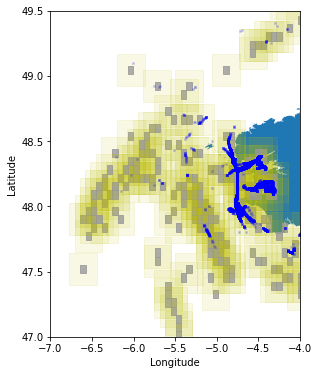

In [13]:
# print grids
ax = utils.createAXNFigure(coastline_path="../../testData/EuropeanCoastline/Europe Coastline (Polygone).shp", zoom_in=True)
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))

#
# for row in df_a.collect():
#   ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in geom_b_df.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Plot points from B that are in grid

In [14]:
filltered_df = spatial_join_b_result.filter(F.col("grid_id").isNotNull())
filltered_df.show()

+--------------------+----------+---------+-----------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+-------+
|                 _id|         X|        Y|exp_grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|count|grid_id|
+--------------------+----------+---------+-----------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+-------+
|60039bef2bc024099...|  -4.50088| 48.35698|       1413| -4.47267| 48.37856| -4.53637| 48.31485|     -4.33727|     48.46849|     -4.67177|     48.22492| 2969|   1413|
|60039b8f2bc024099...|-4.4970617|48.379555|       1412| -4.47267| 48.44226| -4.53637| 48.37856|      -4.3371|     48.53219|     -4.67194|     48.28862| 6514|   1412|
|60039b9c2bc024099...|-4.4137635| 48.15062|       1457| -4.40896| 48.18745| -4.47267| 48.12374|     -4.27407|     48.27738|     -4.60756|     48.03381|  582|   1457|
|600

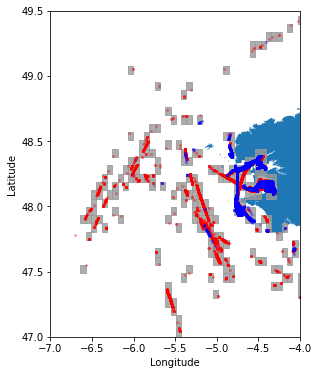

In [15]:
# print grids
ax = utils.createAXNFigure(coastline_path="../../testData/EuropeanCoastline/Europe Coastline (Polygone).shp", zoom_in=True)
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    # exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    # ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))


for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in filltered_df.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Find matching points/pairs

As a first filter of matching point we use the fact that each pair point in the same
grid between 2 datasets satisfied the theta condition so:
- We perform a filter on point set B in order to keep only those points that has been
assigned in a grid
- then we perform a simple join with points from point set A based on grid id to find all
valid pairs given by grids
- then write the result into a file (override result if file exits)

### SOS gia tin ilopoiisi
- to filtrarisma tha ginei kratontas osa point exoun idio grid kai expanded grid id

In [17]:
# timing procedure
start_time = time.time()

filtered_a_results = spatial_join_result \
    .select(F.col("_id").alias("a_id"),
            F.col("X").alias("a_X"),
            F.col("Y").alias("a_Y"),
            F.col("grid_id").alias("a_grid_id"))\
    .cache()

filtered_b_results = spatial_join_b_result \
        .filter(F.col("grid_id") == F.col("exp_grid_id")) \
        .select(F.col("_id").alias("b_id"), F.col("grid_id").alias("b_grid_id"))


ta = filtered_a_results.alias('ta')
tb = filtered_b_results.alias('tb')


first_result = ta.join(tb, ta.a_grid_id == tb.b_grid_id)\
        .select(F.col("a_id"), F.col("b_id"))

# write file
print(first_result.count())#.write.save("dist_join_result.csv", format="csv", mode="overwrite")

print("--- %s seconds ---" % (time.time() - start_time))

87241836
--- 1.2699298858642578 seconds ---


## Find matching points using expanded grids
Now we have to check for matching pairs between points from point set A that are in
grid and points from pointest B that ar in the same expanded grid and not in the grid

- declare a udf for haversian distance
- first get all points with null grid from joined pointset B
-

In [18]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

udfsomefunc = F.udf(haversine, DoubleType())

In [19]:
# timing procedure
start_time = time.time()

filtered_b_in_exp_grid = spatial_join_b_result.where(F.col("grid_id").isNull()) \
        .select(F.col("_id").alias("b_id"),
                F.col("X").alias("b_X"),
                F.col("Y").alias("b_Y"),
                F.col("exp_grid_id").alias("b_exp_grid_id"))

tb = filtered_b_in_exp_grid.alias('tb')

"""
  Using approximation that 1 degree on earth is 111km
"""
if distanceType != "haversine":
    kmPerDegree = 1 / 111
    targetDist = kmPerDegree * theta
    final_result = ta.join(tb, ta.a_grid_id == tb.b_exp_grid_id)\
            .where(F.sqrt(pow(F.col("a_X") - F.col("b_X"), 2) + pow(F.col("a_Y") - F.col("b_Y"), 2)) <= targetDist)\
            .select(F.col("a_id"), F.col("b_id"))

else:
    """
        Haversine using spark F functions
    """
    final_result = ta.join(tb, ta.a_grid_id == tb.b_exp_grid_id)\
        .withColumn("a", (
            F.pow(F.sin((F.radians(F.col("b_Y") - F.col("a_Y"))) / 2), 2) +
            F.cos(F.radians(F.col("a_Y"))) * F.cos(F.radians(F.col("b_Y"))) *
            F.pow(F.sin((F.radians(F.col("b_X") - F.col("a_X"))) / 2), 2)))\
        .withColumn("haversine_dist", F.asin(F.sqrt(F.col("a"))) * 12742)\
        .filter(F.col("haversine_dist") <= theta)\
        .select(F.col("a_id"), F.col("b_id"))

"""
    UDF Haversine distance
"""
    # final_result = ta.join(tb, ta.a_grid_id == tb.b_exp_grid_id)
    # final_result = final_result.withColumn("haversine_dist",
    #                                        udfsomefunc(F.col("a_X"), F.col("a_Y"), F.col("b_X"), F.col("b_Y"))) \
    #     .filter(F.col("haversine_dist") <= theta)


final_result.show(10)
print(final_result.count())

print("--- %s seconds ---" % (time.time() - start_time))


+--------------------+--------------------+
|                a_id|                b_id|
+--------------------+--------------------+
|60039e172bc024099...|60039bef2bc024099...|
|60039e102bc024099...|60039bef2bc024099...|
|60039e542bc024099...|60039bef2bc024099...|
|60039e102bc024099...|60039bef2bc024099...|
|60039e542bc024099...|60039bef2bc024099...|
|60039e102bc024099...|60039bef2bc024099...|
|60039e542bc024099...|60039bef2bc024099...|
|60039e102bc024099...|60039bef2bc024099...|
|60039e542bc024099...|60039bef2bc024099...|
|60039e102bc024099...|60039bef2bc024099...|
+--------------------+--------------------+
only showing top 10 rows

132511812
--- 4.4132091999053955 seconds ---


In [20]:
print("--- TOTAL EXECUTION TIME ---\n--- %s seconds ---" % (time.time() - total_time))



--- TOTAL EXECUTION TIME ---
--- 555.2023487091064 seconds ---
